# Weather Changes Over Time (Consuming APIs)

## Task
Utilize the following two APIs to evaluate the changes in temperature for your birthday and city you were born in:
* [geocode.xyz](geocode.xyz)
* [open-meteo.com](open-meteo.com)


In [1]:
from datetime import date, datetime, timedelta

import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_palette('muted')
sns.set_style('white')

## Question 1: Geocoding A Location

Write a function that utilizes the [geocode.xyz](geocode.xyz) API to take in a city and country and return the latitude and longitude of that location

```
def geocode_location(city, country):
    # your code
    return latitude, longitude
```

For example:
```
geocode_location("london", "united kingdom")
```
should return
```
(-0.11534, 51.49742)
```

In [8]:
def geocode_location(city, country):
    base_url = 'https://geocode.xyz/'
    response = requests.get(f'{base_url}', params={'locate': f'{city}, {country}', 'geoit': 'JSON'})
    body = response.json()
    longt = body['longt']
    latt = body['latt']
    return latt, longt

In [9]:
location = geocode_location('Detroit', 'United states of america')
location

('42.38833', '-83.10352')

## Question 2: Determining Weather Using Date and Location
Write a function that utilizes the [open-meteo.com](https://open-meteo.com/) API to take in a date and location and return the 15-day average high and low for the following measurements from the years 1960 to 2022:
* `precipitation_sum` (mm): Sum of daily precipitation (including rain, showers and snowfall)
* `temperature_2m_max` (°F): Maximum daily air temperature at 2 meters above ground
* `temperature_2m_min` (°F): Minimum daily air temperature at 2 meters above ground
* `apparent_temperature_max` (°F): Maximum daily apparent temperature
* `apparent_temperature_min` (°F): Min daily apparent temperature

The function should return the above measurements in a dictionary object with the keys being `"precipitation_sum"`, `"temperature_2m_max"`, etc. and the values being the 15-day average of the measurements. The 15-day average should be the 7 days preceeding the input date, the input date, and the 7 days following the input date. This will give the results more statistical validity by increasing the number of samples for each measurement.

The `get_historical_weather_measurements()` function will include a few different sub-tasks:

### Create API Request in Postman/Insomnia
Use the following [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#api-documentation) page to create an API request that responds with a JSON object of the measurements listed above. Make sure the response object meets the following:
* Temperatue measurements are in Fahrenheit
* Precipitation measurements are in inches
* Measurements are daily aggregations
* 15 day range of weather
* JSON format

Before writing any code, use Postman/Insomnia to create the API request and take a screenshot of the request/response.

#### HINT: How to insert a screenshot
1. Take a screenshot and save it to a file.
2. Create a markdown cell in your notebook.
3. Insert the image into the markdown cell.
  * Option 1: Drag the image file into the markdown cell. This embeds the image data directly into your Jupyter notebook.
  * Option 2: Move the file into the directory with your notebook file (inside the project folder that you will submit). Add markdown to insert the image: `![alternative text](path-to-image)`

### Create API Request Function
Convert the request above into a function. The function should take in `latitude`, `longitude`, and `date` as its arguments and return the API response, if successful.

```
def get_api_response(latitude, longitude, date):
    # your code

```

Use the helper function below for creating a 15-day date range

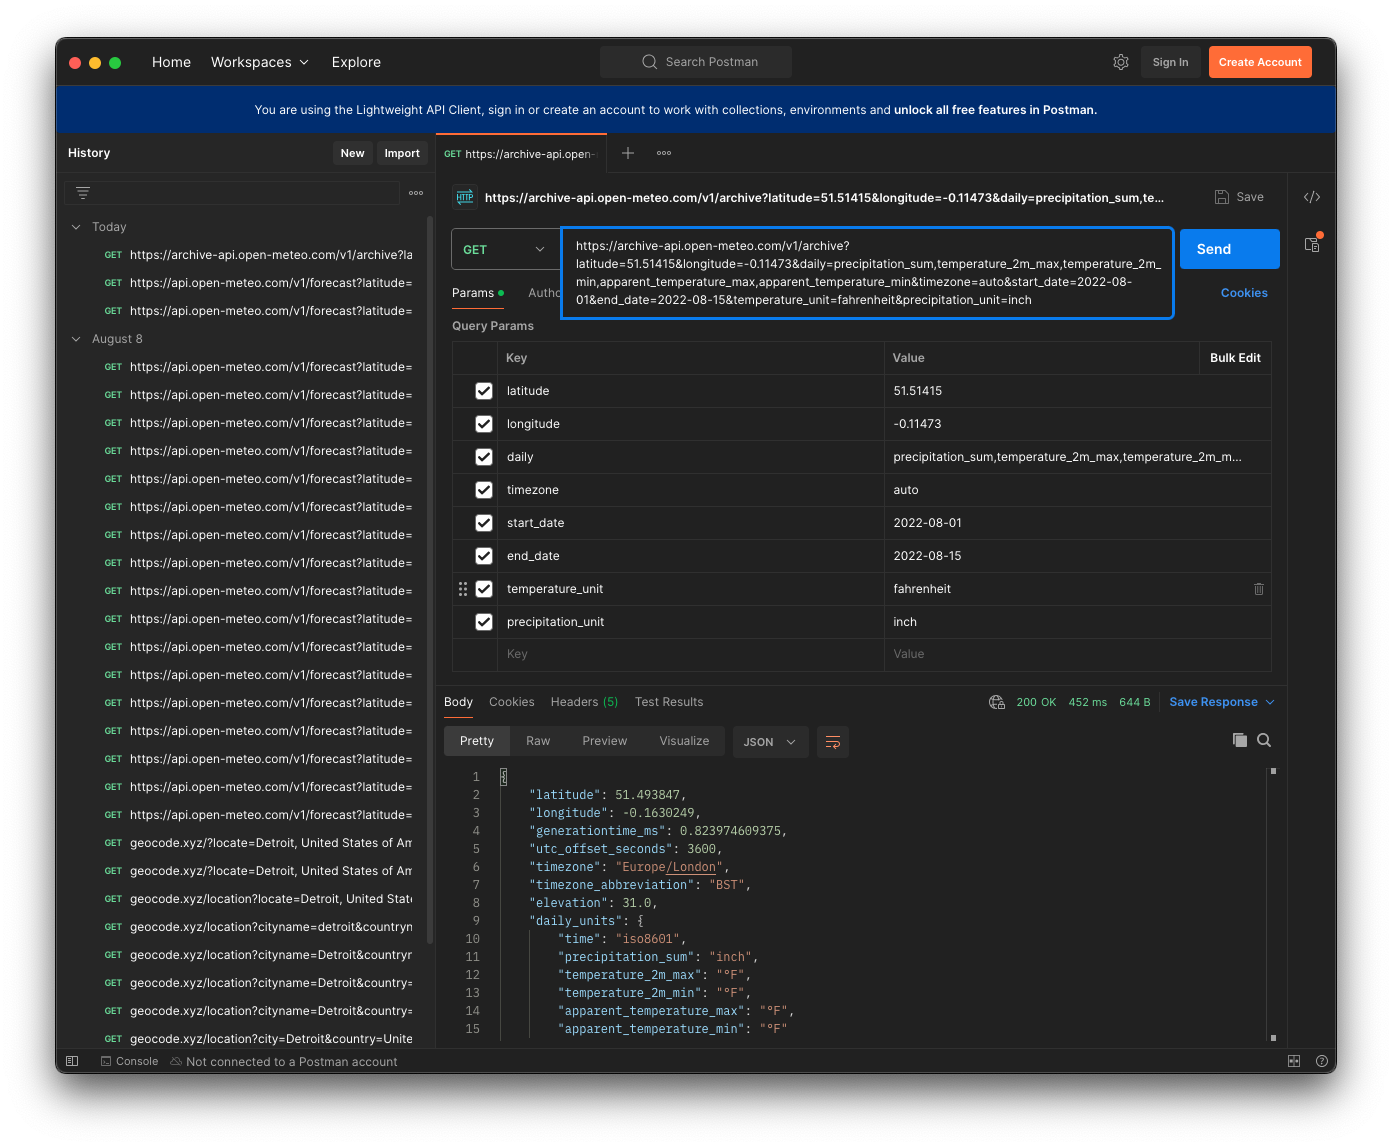

In [10]:
# helper function for 15-day date range
def get_date_range(birthday):
    return {'start_date': birthday - timedelta(days=7),
            'end_date': birthday + timedelta(days=7)
           }

In [11]:
def get_api_response(latitude, longitude, date):
    date_range = get_date_range(date)
    base_url = 'https://archive-api.open-meteo.com'
    response = requests.get(
        f'{base_url}/v1/archive', 
        params={
            'latitude': latitude, 
            'longitude': longitude, 
            'daily': ('precipitation_sum','temperature_2m_max','temperature_2m_min','apparent_temperature_max','apparent_temperature_min'), 
            'timezone': 'auto', 
            'start_date': date_range['start_date'], 
            'end_date': date_range['end_date'], 
            'temperature_unit': 'fahrenheit', 
            'precipitation_unit': 'inch'})
    return response

In [12]:
# hiding this for length in final notebook
# body2 = get_api_response(location[0], location[1], date(1988, 10, 18)).json()
# body2

### Iterating Over Each Year
Write a function that iterates through each year between 1960 and 2022 and returns the corresponding JSON response objects containing weather data for each year in a python list.

```
def get_all_response_objects(start_year, end_year):
    # your code
```


In [13]:
def get_all_response_objects(latitude, longitude, birthday: date):
    response_objects = list()
    for i in range(1960, 2023):
        weather = get_api_response(latitude, longitude, date(i, birthday.month, birthday.day)).json()
        response_objects.append(weather)
    return response_objects

weather_range = get_all_response_objects(location[0], location[1], date(1988, 10, 18))

### Parse JSON Responses & Aggregate Data
Write a function that takes the list of JSON response objects from the previous function in as a parameter and returns a pandas DataFrame containing the original input date, the measurements, and the average across the 15 days.
```
def parse_json_response(responses):
    # your code
```


In [14]:
import statistics as stats

In [67]:
def parse_json_response(responses):
    df = pd.DataFrame()
    avg_list_precip = list()
    avg_list_temp_max = list()
    avg_list_temp_min = list()
    avg_list_app_max = list()
    avg_list_app_min = list()
    year_list = list()
    date_list = list()
    for i in responses:
        avg_list_precip.append(stats.mean(i['daily']['precipitation_sum']))
        avg_list_temp_max.append(stats.mean(i['daily']['temperature_2m_max']))
        avg_list_temp_min.append(stats.mean(i['daily']['temperature_2m_min']))
        avg_list_app_max.append(stats.mean(i['daily']['apparent_temperature_max']))
        avg_list_app_min.append(stats.mean(i['daily']['apparent_temperature_min']))
        year_list.append(int(i['daily']['time'][7][0:4]))
        date_list.append(i['daily']['time'][7][5:])
    df['Year'] = year_list
    df['Date'] = date_list
    df['Precipitation'] = avg_list_precip
    df['Max Temperature'] = avg_list_temp_max
    df['Min Temperature'] = avg_list_temp_min
    df['Max Apparent Temperature'] = avg_list_app_max
    df['Min Apparent Temperature'] = avg_list_app_min

    return df

weather_df = parse_json_response(weather_range)
weather_df.head(10)

,Year,Date,Precipitation,Max Temperature,Min Temperature,Max Apparent Temperature,Min Apparent Temperature
0,1960,10-18,0.063067,59.840000,45.300000,54.713333,39.480000
1,1961,10-18,0.067400,63.006667,48.233333,58.226667,42.820000
2,1962,10-18,0.087000,61.946667,46.840000,57.713333,41.313333
3,1963,10-18,0.000800,73.433333,52.460000,69.306667,49.533333
4,1964,10-18,0.020733,58.480000,38.906667,52.566667,32.960000
5,1965,10-18,0.137533,58.513333,45.420000,54.393333,39.546667
6,1966,10-18,0.069267,56.620000,43.226667,50.126667,36.233333
7,1967,10-18,0.146467,56.693333,43.060000,51.000000,37.180000
8,1968,10-18,0.034933,64.446667,49.560000,60.706667,46.206667
9,1969,10-18,0.071133,55.826667,42.860000,49.786667,35.806667


In [68]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      63 non-null     int64  
 1   Date                      63 non-null     object 
 2   Precipitation             63 non-null     float64
 3   Max Temperature           63 non-null     float64
 4   Min Temperature           63 non-null     float64
 5   Max Apparent Temperature  63 non-null     float64
 6   Min Apparent Temperature  63 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.6+ KB


### Combining the Functions
Write a function that combines all the above functions into one, where the user inputs their birthday and location and the function returns the pandas DataFrame containing the summary of measurements.

```
def get_data():
    birthday = get_user_birthday()
    location = get_user_city_of_birth()
    # your code here
```

The helper functions below can be used for birthday and location input information:

In [69]:
# helper functions
def get_user_birthday():
    birthday = input('Enter your birthday (MM/DD/YYYY): ')
    return datetime.strptime(birthday, "%m/%d/%Y")

def get_user_city_of_birth():
    city = input('Enter the city you were born in: ')
    country = input('Enter the country you were born in: ')
    return city , country

In [70]:
def get_data():
    birthday = get_user_birthday()
    city, country = get_user_city_of_birth()
    latitude, longitude = geocode_location(city, country)
    responses = get_all_response_objects(latitude, longitude, birthday)
    return parse_json_response(responses)

Run your function and set it equal to `df`:

In [77]:
df = get_data()

df.head()

Enter your birthday (MM/DD/YYYY):  10/18/1988
Enter the city you were born in:  Detroit
Enter the country you were born in:  United States of America


,Year,Date,Precipitation,Max Temperature,Min Temperature,Max Apparent Temperature,Min Apparent Temperature
0,1960,10-18,0.063067,59.840000,45.300000,54.713333,39.480000
1,1961,10-18,0.067400,63.006667,48.233333,58.226667,42.820000
2,1962,10-18,0.087000,61.946667,46.840000,57.713333,41.313333
3,1963,10-18,0.000800,73.433333,52.460000,69.306667,49.533333
4,1964,10-18,0.020733,58.480000,38.906667,52.566667,32.960000


## Question 3: Visualizing The Data
Plot the DataFrame using `matplotlib`/`seaborn` and write a short summary of your results.

In [78]:
import warnings
warnings.filterwarnings('ignore') # getting rid of FutureWarnings

[Text(0.5, 1.0, 'Precipitation Trends over the years on 10-18'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Precipitation in Inches')]

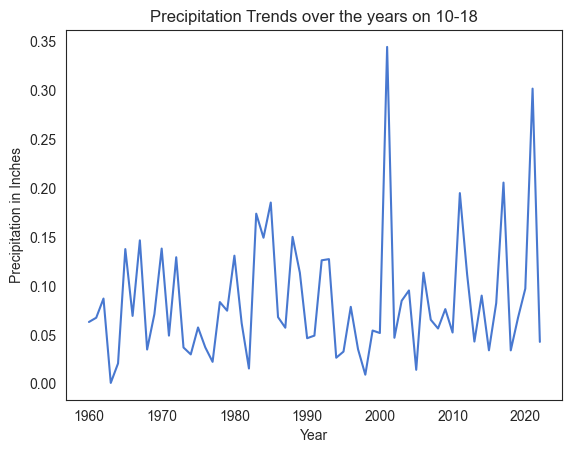

In [79]:
sns.lineplot(data=df, x='Year', y='Precipitation').set(
    title=f'Precipitation Trends over the years on {df.Date[0]}', 
    xlabel='Year', ylabel='Precipitation in Inches')

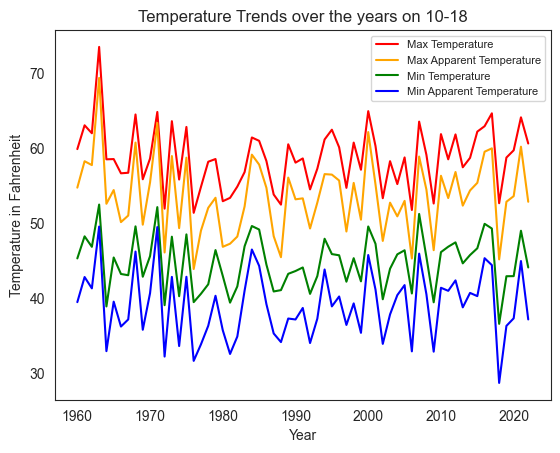

In [86]:
fig, ax = plt.subplots()
ax.plot(df['Year'], df['Max Temperature'], label='Max Temperature', color='red')
ax.plot(df['Year'], df['Max Apparent Temperature'], label='Max Apparent Temperature', color='orange')
ax.plot(df['Year'], df['Min Temperature'], label='Min Temperature', color='green')
ax.plot(df['Year'], df['Min Apparent Temperature'], label='Min Apparent Temperature', color='blue')
ax.set(title=f'Temperature Trends over the years on {df.Date[0]}', xlabel='Year', ylabel='Temperature in Fahrenheit')
ax.legend(loc ='upper right', fontsize='8')

### Results Summary:

The most extreme precipitation happened in the early 2000s, but it seems the higest temps were earlier in the data. The Max Temp, Max Apparent Temp, Min Temp, and Min Apparent Temp all seem to have a high positive correlation coefficient, chart added below to confirm.

In [85]:
df_corr = df.drop(['Year', 'Date'], axis=1)
df_corr.corr()

,Precipitation,Max Temperature,Min Temperature,Max Apparent Temperature,Min Apparent Temperature
Precipitation,1.000000,-0.002697,0.180253,0.057267,0.158285
Max Temperature,-0.002697,1.000000,0.869675,0.979010,0.874883
Min Temperature,0.180253,0.869675,1.000000,0.908248,0.987851
Max Apparent Temperature,0.057267,0.979010,0.908248,1.000000,0.925718
Min Apparent Temperature,0.158285,0.874883,0.987851,0.925718,1.000000
